In [21]:
'''
feature selection with Boruta
'''
import os, sys
from datetime import datetime
import argparse
import pandas as pd
import numpy as np
import torch
import optuna
from sklearn.model_selection import KFold
from boruta import BorutaPy
from BorutaShap import BorutaShap
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import plotly.graph_objects as go
import json
import pickle
# 检测运行环境
def in_notebook():
    return 'IPKernelApp' in getattr(globals().get('get_ipython', lambda: None)(), 'config', {})

if in_notebook():
    from IPython.display import clear_output, display
    notebook_dir = os.getcwd()
    src_path = os.path.abspath(os.path.join(notebook_dir, '..'))
    N_TRIAL = 100 # boruta 特征选择次数
    OUTCOME_IX = 0
    IMPORTANCE_MEASURE = 'gini' # gini, shap, perm
else:
    src_path = os.path.abspath(os.path.dirname(os.path.dirname(__file__)))
    parser = argparse.ArgumentParser(description='')
    parser.add_argument('-n',metavar= 50, type=int, default=1000,help='''optuna优化尝试次数''')
    parser.add_argument('-outcome_ix',metavar=0, type=int, default=0,help='''选择预测结局, 为 `get_ite_features()`返回的预设 outcomes 列表的索引''')
    parser.add_argument('-importance',metavar='gini', type=str, default='shap',help='''特征重要性度量方式''')
    sys_args = parser.parse_args()
    N_TRIAL = sys_args.n
    OUTCOME_IX = sys_args.outcome_ix
    IMPORTANCE_MEASURE = sys_args.importance

sys.path.append(src_path) if src_path not in sys.path else None
from src.utils import *
from src.model_utils import *
from src.setup import *

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'current device: {DEVICE}')
DATASET='EXIT_SEP'
current_time = datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d_%H-%M")

current device: cpu


In [22]:
df = pd.read_csv(f'{DATA}/imputed/EXIT_SEP_clean_imputed.tsv.gz', sep='\t', index_col='ID')
cate_vars, cont_vars, outcomes = get_cleaned_vars('EXIT_SEP')

X = df[[*cate_vars, *cont_vars]].copy()
y = df[outcomes[OUTCOME_IX]].copy()

In [23]:
corr_mat = X.corr()
for col in corr_mat.columns:
    mask_high_corr = (corr_mat[col] > 0.9) & (corr_mat[col].index != col)
    high_corr = (corr_mat[col][mask_high_corr]).to_dict()
    for var, corr_coef in high_corr.items():
        print(f'{col} x {var} : {corr_coef:.2f}')

SOFA_renal x Scr : 0.90
Respiratory_Support x MV : 0.96
Respiratory_Support x MV/NIPPV : 0.96
MV x Respiratory_Support : 0.96
MV/NIPPV x Respiratory_Support : 0.96
Scr x SOFA_renal : 0.90


In [24]:
# 去除高相关性特征和综合评分
X = X.drop(columns=['RBC', 'HCT', 'ALT',
                    'Respiratory_Support', 'MV', 
                    'APACHE_II','SOFA','SOFA_renal', 'SOFA_cardio', 'SOFA_coagulation', 'SOFA_liver', 'SOFA_respiration', #'SOFA_cns',
                   ])

In [32]:
# model = XGBClassifier(n_estimators=200, 
#                       objective='binary:logistic', eval_metric='logloss',
#                       tree_method="hist",
#                       booster='gbtree',
#                       n_jobs=-1,
#                       device = DEVICE)

feature_selector = BorutaShap(
                              # model=model, 
                              # importance_measure='shap',
                              importance_measure=IMPORTANCE_MEASURE,
                              classification=True,
                              pvalue=0.10)

feature_selector.fit(X, y, 
                     n_trials=N_TRIAL, 
                     random_state=19960816,
                     sample=True,
                     train_or_test='test', 
                     normalize=True,
                     verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

11 attributes confirmed important: ['K+', 'Scr', 'BUN', 'NE%', 'age', 'heart_rate', 'APTT', 'PLT', 'Lac', 'Na+', 'PaO2/FiO2']
44 attributes confirmed unimportant: ['D-Dimer', 'pathogen_test', 'sex', 'CRP', 'Fg', 'Gram_pos_resist', 'nutri_support_enteral', 'MAP', 'WBC', 'PaCO2', 'SBP', 'STB', 'Fungi_infect', 'BMI', 'SOFA_cns', 'AST', 'PH', 'PT', 'nutri_support', 'primary_infection_site_brain', 'multidrug_resist', 'NIPPV', 'primary_infection_site_lung', 'nutri_support_parenteral', 'PCT', 'Gram+_infect', 'septic_shock', 'XBJ_intervention', 'PaO2', 'temperature', 'Glu', 'primary_infection_site_uri', 'Hb', 'respiratory_rate', 'Fungi_resist', 'HCO3-', 'MV/NIPPV', 'CCRT', 'primary_infection_site_abdo', 'Gram_neg_resist', 'primary_infection_site_skin', 'DIC-score', 'DBP', 'Gram-_infect']
1 tentative attributes remains: ['LYM%']


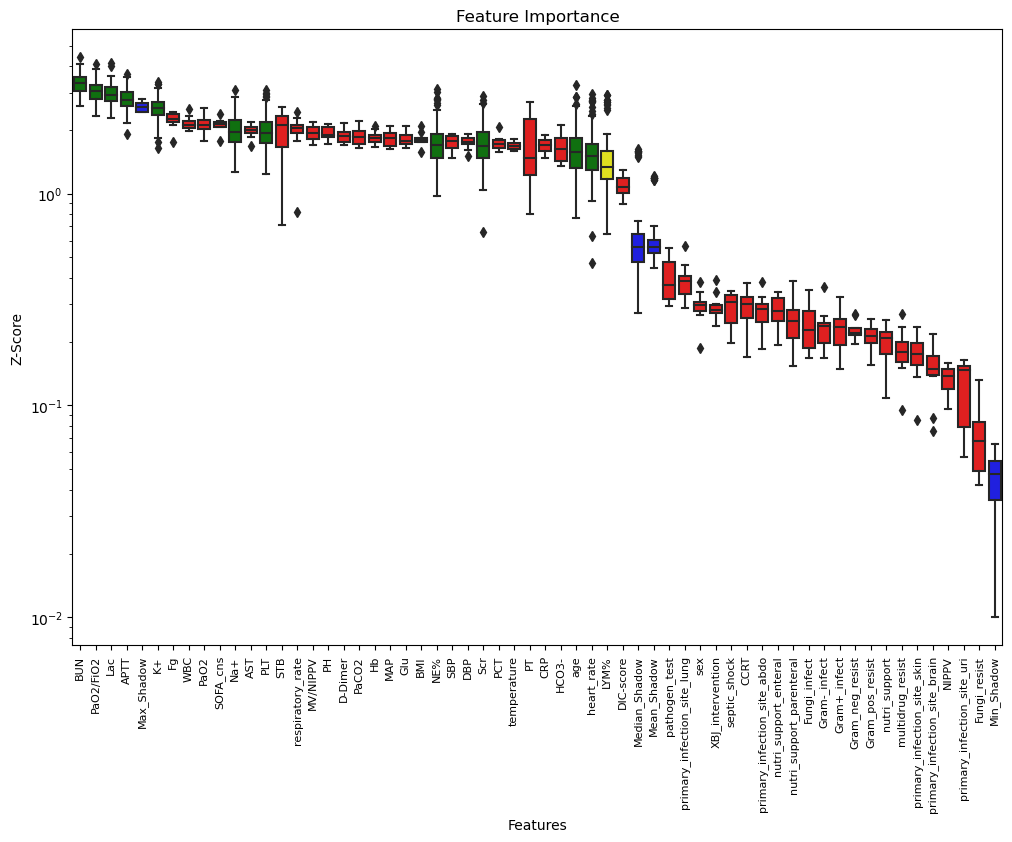

In [33]:
feature_selector.plot()

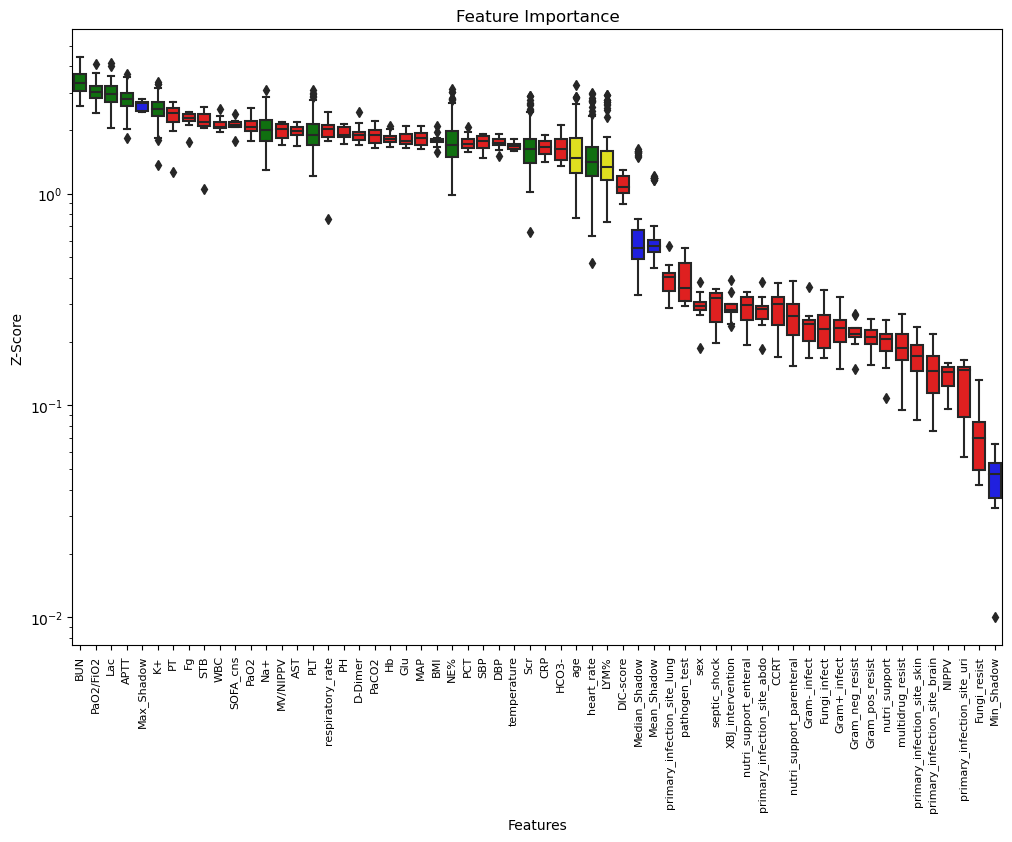

In [31]:
feature_selector.results_to_csv(f'{TABLES}/{DATASET}_boruta_{formatted_time}.csv')
feature_selector.plot()
# 10 attributes confirmed important: ['K+', 'Scr', 'BUN', 'NE%', 'heart_rate', 'APTT', 'PLT', 'Lac', 'Na+', 'PaO2/FiO2']
# 44 attributes confirmed unimportant: ['D-Dimer', 'pathogen_test', 'sex', 'Fg', 'Gram_pos_resist', 'CRP', 'nutri_support_enteral', 'MAP', 'WBC', 'PaCO2', 'SBP', 'STB', 'Fungi_infect', 'BMI', 'SOFA_cns', 'AST', 'PH', 'PT', 'nutri_support', 'primary_infection_site_brain', 'multidrug_resist', 'NIPPV', 'primary_infection_site_lung', 'nutri_support_parenteral', 'PCT', 'Gram+_infect', 'septic_shock', 'XBJ_intervention', 'PaO2', 'temperature', 'Glu', 'primary_infection_site_uri', 'Hb', 'respiratory_rate', 'Fungi_resist', 'HCO3-', 'MV/NIPPV', 'CCRT', 'primary_infection_site_abdo', 'Gram_neg_resist', 'primary_infection_site_skin', 'DIC-score', 'DBP', 'Gram-_infect']
# 2 tentative attributes remains: ['age', 'LYM%']

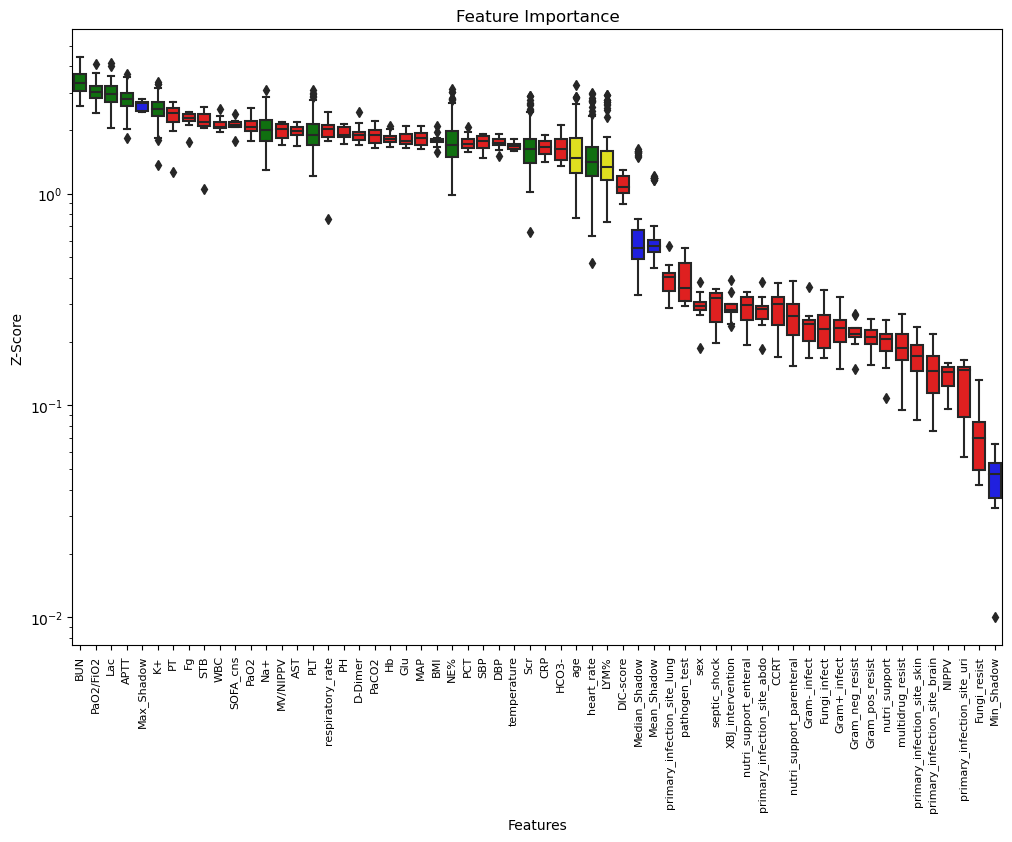

In [26]:
feature_selector.plot()
# 10 attributes confirmed important: ['K+', 'Scr', 'BUN', 'NE%', 'heart_rate', 'APTT', 'PLT', 'Lac', 'Na+', 'PaO2/FiO2']
# 44 attributes confirmed unimportant: ['D-Dimer', 'pathogen_test', 'sex', 'Fg', 'Gram_pos_resist', 'CRP', 'nutri_support_enteral', 'MAP', 'WBC', 'PaCO2', 'SBP', 'STB', 'Fungi_infect', 'BMI', 'SOFA_cns', 'AST', 'PH', 'PT', 'nutri_support', 'primary_infection_site_brain', 'multidrug_resist', 'NIPPV', 'primary_infection_site_lung', 'nutri_support_parenteral', 'PCT', 'Gram+_infect', 'septic_shock', 'XBJ_intervention', 'PaO2', 'temperature', 'Glu', 'primary_infection_site_uri', 'Hb', 'respiratory_rate', 'Fungi_resist', 'HCO3-', 'MV/NIPPV', 'CCRT', 'primary_infection_site_abdo', 'Gram_neg_resist', 'primary_infection_site_skin', 'DIC-score', 'DBP', 'Gram-_infect']
# 2 tentative attributes remains: ['age', 'LYM%']

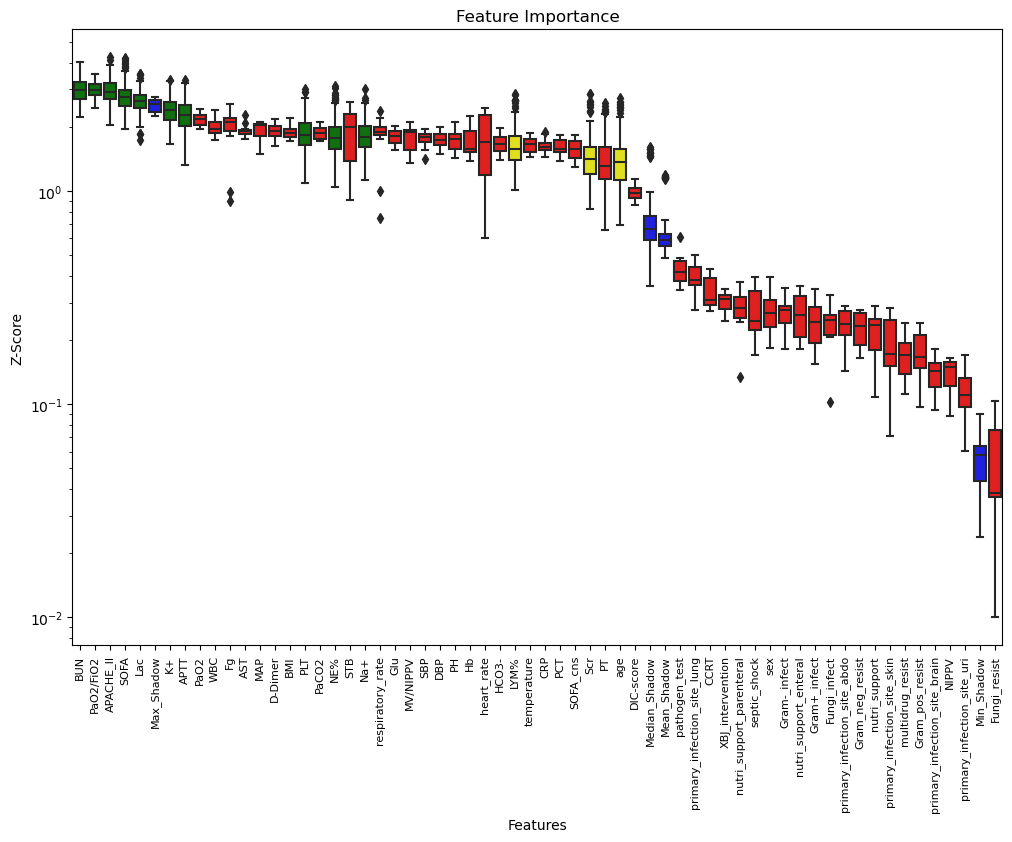

In [15]:
feature_selector.plot()
# 10 attributes confirmed important: ['K+', 'BUN', 'NE%', 'SOFA', 'APACHE_II', 'APTT', 'PLT', 'Lac', 'Na+', 'PaO2/FiO2']
# 45 attributes confirmed unimportant: ['D-Dimer', 'pathogen_test', 'heart_rate', 'sex', 'CRP', 'Gram_pos_resist', 'Fg', 'nutri_support_enteral', 'MAP', 'WBC', 'PaCO2', 'SBP', 'STB', 'Fungi_infect', 'BMI', 'SOFA_cns', 'AST', 'PH', 'PT', 'nutri_support', 'primary_infection_site_brain', 'multidrug_resist', 'NIPPV', 'primary_infection_site_lung', 'nutri_support_parenteral', 'PCT', 'Gram+_infect', 'septic_shock', 'XBJ_intervention', 'PaO2', 'temperature', 'Glu', 'primary_infection_site_uri', 'Hb', 'respiratory_rate', 'Fungi_resist', 'HCO3-', 'MV/NIPPV', 'CCRT', 'primary_infection_site_abdo', 'Gram_neg_resist', 'primary_infection_site_skin', 'DIC-score', 'DBP', 'Gram-_infect']
# 3 tentative attributes remains: ['Scr', 'age', 'LYM%']

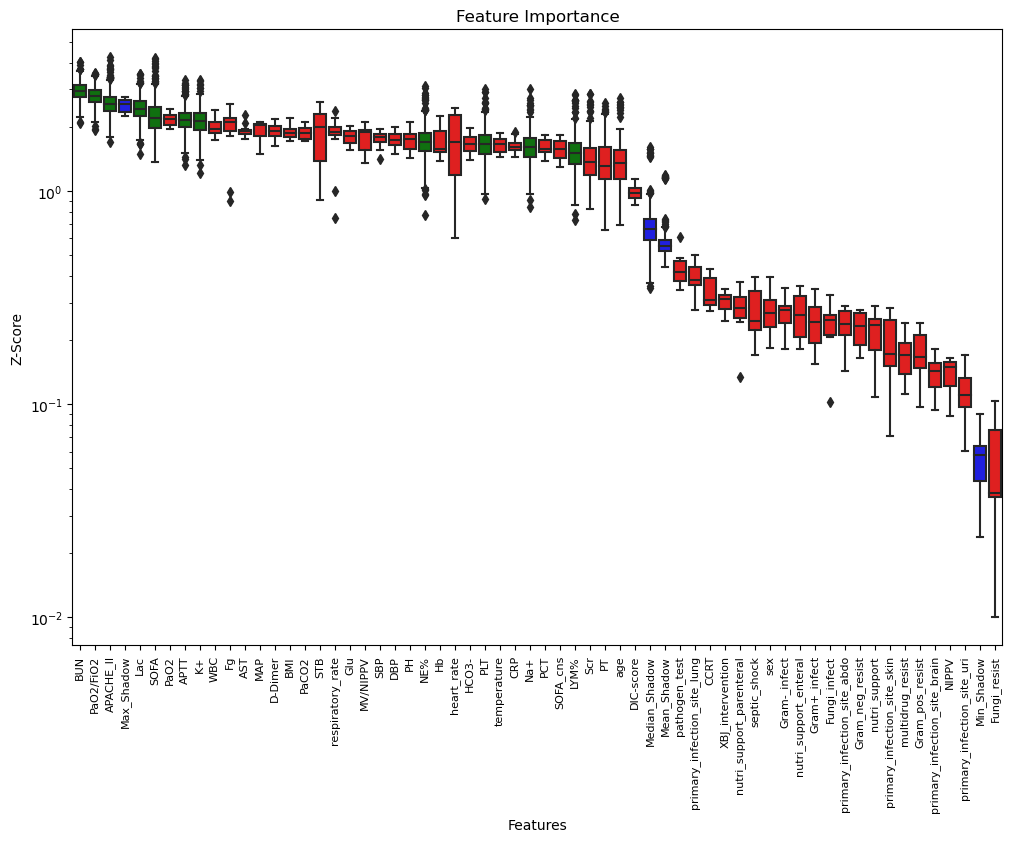

In [7]:
feature_selector.plot()

In [9]:
feature_selector_path = f'{MODELS}/{DATASET}_boruta_risk_model_{outcomes[OUTCOME_IX]}_{IMPORTANCE_MEASURE}.pkl'
with open(feature_selector_path, 'wb') as file:
    pickle.dump(feature_selector, file)
print(f"Feature selector saved: {feature_selector_path}")

Feature selector saved: /home/xuxu.wei/sepsis-reasearch//models//EXIT_SEP_boruta_risk_model_28d_mortality_gini.pkl
